<a class="anchor" id="0"></a>
# **Complete Step-by-step Guide on Time Series Forecasting in Python**

### Hello everyone!

Welcome to my notebook on time-series analysis! Here, I’ll take you through the fascinating process of analyzing weather data to uncover trends, seasonal patterns, and anomalies.

We’ll begin with trend analysis, using rolling averages and decomposition methods to observe long-term shifts influenced by climate change. Then, we’ll explore seasonality, identifying recurring weather cycles like monsoon humidity spikes or winter temperature drops. Along the way, we’ll examine correlations between variables, such as how changes in wind speed might impact temperature or pressure.

One of the most exciting aspects of this journey is anomaly detection—spotting rare events like sudden temperature spikes or abrupt pressure drops. These anomalies help us better understand extreme weather patterns and improve forecasting accuracy.

Through this notebook, I aim to provide a clear and practical understanding of time-series analysis while uncovering valuable insights from dynamic weather data. Let’s dive in! 🌍✨


### **I hope you find this notebook useful and your <font color="red"><b>UPVOTES</b></font> keep me motivated.**

# 1. Process Diagram

<div style="text-align: center;">
    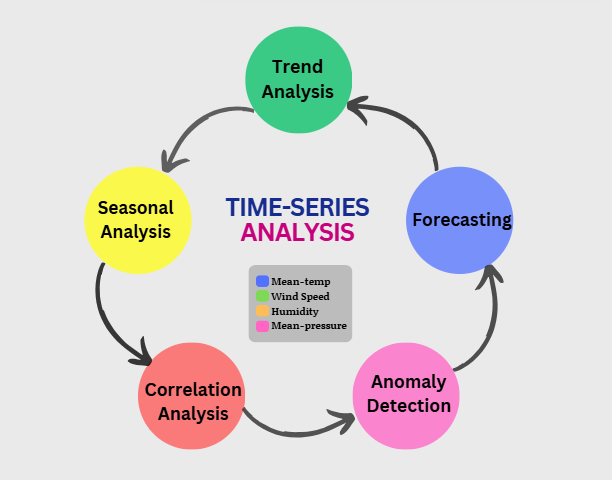
</div>


# 2. All-Used Imported Libraries

In [23]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore

!pip install pmdarima

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [24]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


# 3. Data Collection

In [25]:
# File paths
train_file = "/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv"
test_file = "/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv"

# Load data
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Display basic information
print("Train Dataset Info:")
print(train_data.info())

print("\nTest Dataset Info:")
print(test_data.info())

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB
None


In [26]:
print("\nTrain Dataset Preview:")
train_data.head()


Train Dataset Preview:


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [27]:
print("\nTest Dataset Preview:")
test_data.head()


Test Dataset Preview:


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


## 3.1 Data Understanding

1. Date: This serves as the time index for the time-series analysis.
2. Variables: meantemp, humidity, wind_speed, and meanpressure are the numerical features to analyze over time.
3. Data spans 1462 training days and 114 test days, giving a continuous timeline to work with.

## 3.2 Data Preparation

In [28]:
# Step 1: Combine Train and Test Data for Preprocessing
data = pd.concat([train_data, test_data], ignore_index=True)

# Step 2: Parse 'date' column into datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [29]:
# Step 3: Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [30]:
data['date_index'] = data['date']  # Create a copy

# Step 4: Ensure data is sorted by date
data.sort_values(by='date', inplace=True)

# Step 5: Set the 'date' column as the index
data.set_index('date', inplace=True)

In [31]:
# Step 6: Resample the data to ensure daily frequency
# This ensures uniform spacing in case there are missing dates
data = data.resample('D').mean()

# Step 7: Re-check for missing values after resampling
print("Missing Values After Resampling:\n", data.isnull().sum())

Missing Values After Resampling:
 meantemp        0
humidity        0
wind_speed      0
meanpressure    0
date_index      0
dtype: int64


# 4. Trend Analysis

## 4.1 Basic trend analysis
+ Checking highest and lowest points.

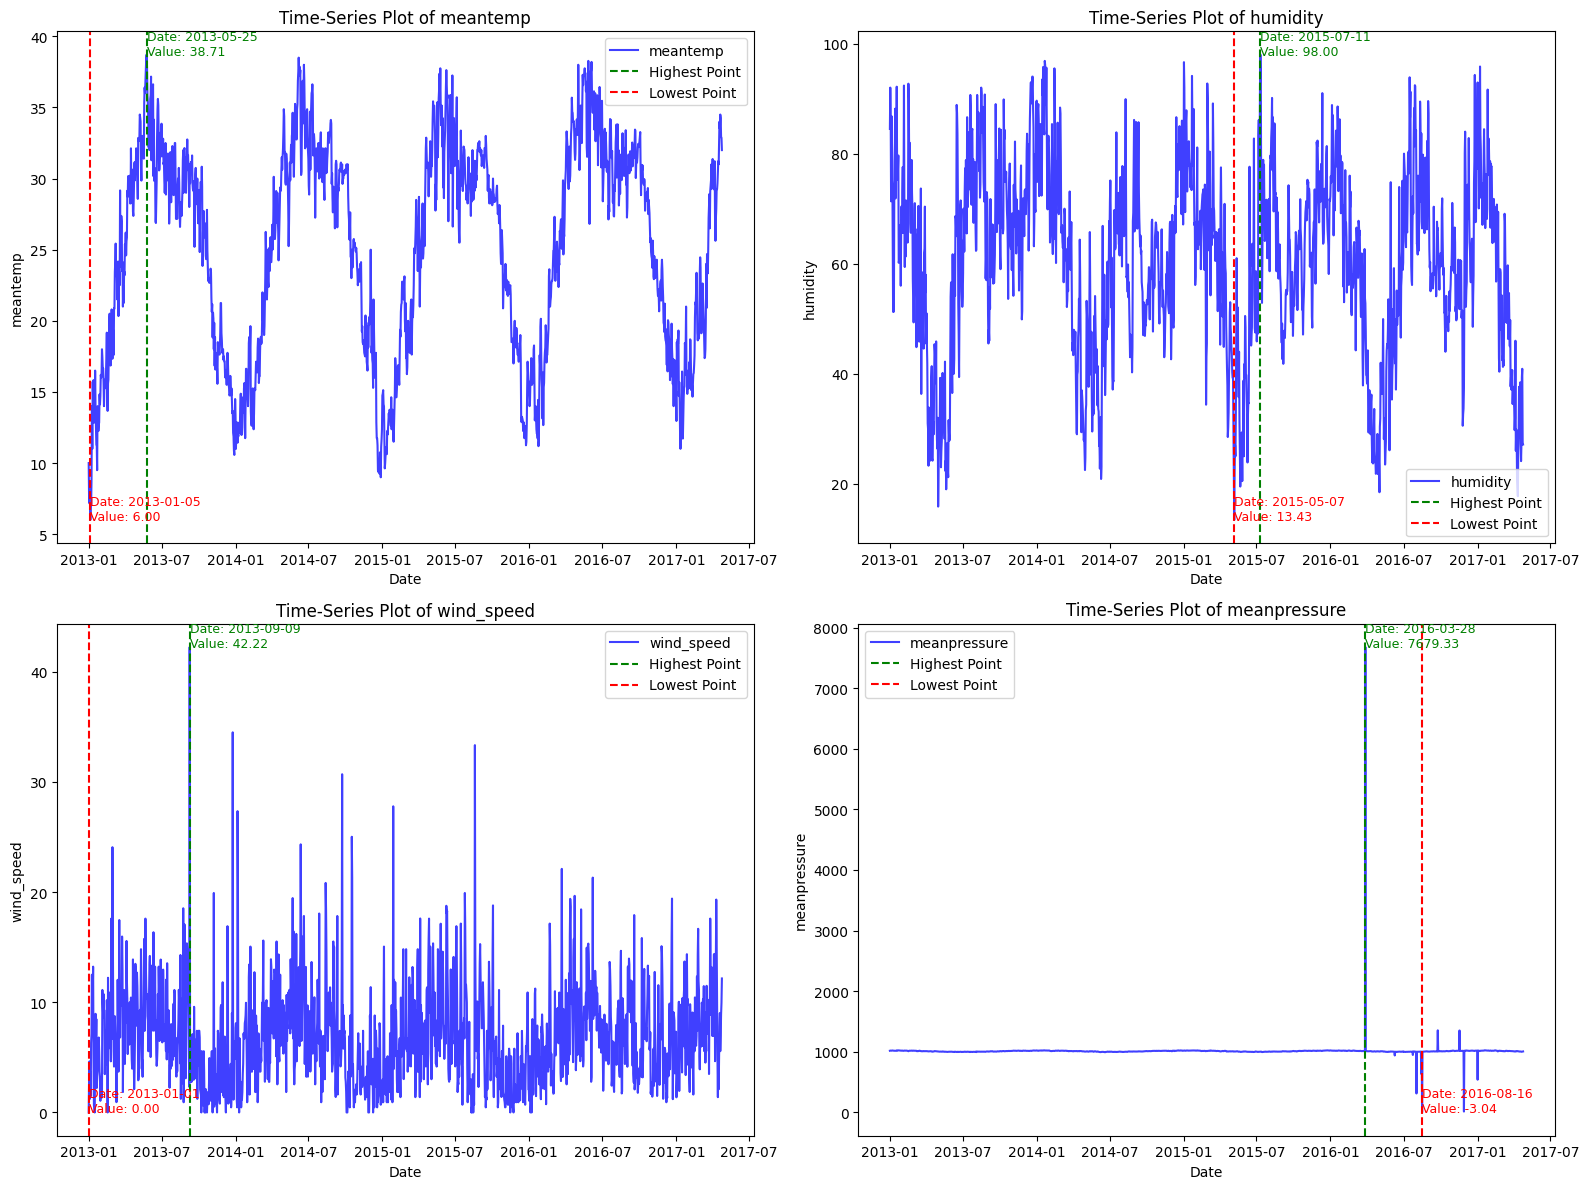

In [32]:
# Plot Time-Series Data with Annotations for High and Low Points
import matplotlib.pyplot as plt

features = ["meantemp", "humidity", "wind_speed", "meanpressure"]

plt.figure(figsize=(16, 12)) 

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    
    # Plot the time series data
    plt.plot(data[feature], label=feature, alpha=0.75, color="blue")
    
    # Identify the highest and lowest points
    max_point = data[feature].idxmax()
    min_point = data[feature].idxmin()
    max_value = data.loc[max_point, feature]
    min_value = data.loc[min_point, feature]
    
    # Highlight the highest point (green)
    plt.axvline(x=max_point, color="green", linestyle="--", label="Highest Point")
    plt.text(max_point, max_value, f"Date: {max_point.date()}\nValue: {max_value:.2f}", 
             color="green", fontsize=9, ha='left')
    
    # Highlight the lowest point (red)
    plt.axvline(x=min_point, color="red", linestyle="--", label="Lowest Point")
    plt.text(min_point, min_value, f"Date: {min_point.date()}\nValue: {min_value:.2f}", 
             color="red", fontsize=9, ha='left')
    
    # Add title and labels
    plt.title(f"Time-Series Plot of {feature}")
    plt.xlabel("Date")
    plt.ylabel(feature)
    
    # Add a legend
    plt.legend()

plt.tight_layout()
plt.show()


**Key Observation:**
* Meantemp: A Cyclical pattern (likely seasonal), with a clear high and low point can be identified. Highest MeanTemp was on 2013-05-25 with 38.71 value and lowest on 2013-01-05 with 6.0.
* Humidity: Noticeable fluctuations with extreme highs and lows. Peaks and troughs are evident. Highest Humidity was on 2015-07-01 with 98.0 and lowest on 2015-05-07 with 13.43.
* Wind Speed: Irregular spikes indicate certain high-speed wind events, with the lowest consistently near zero.
* Mean Pressure: Mostly stable, with a sudden spike on 2016-03-28 with 7679.33 and indicating an outlier or anomaly. Anomaly Detection will be performed on wind speed and pressure for their anomalies behaviour.

## 4.2 Rolling Average
+ Checking seasonal pattern with trend smoothening for 7-months and 30-days interval.

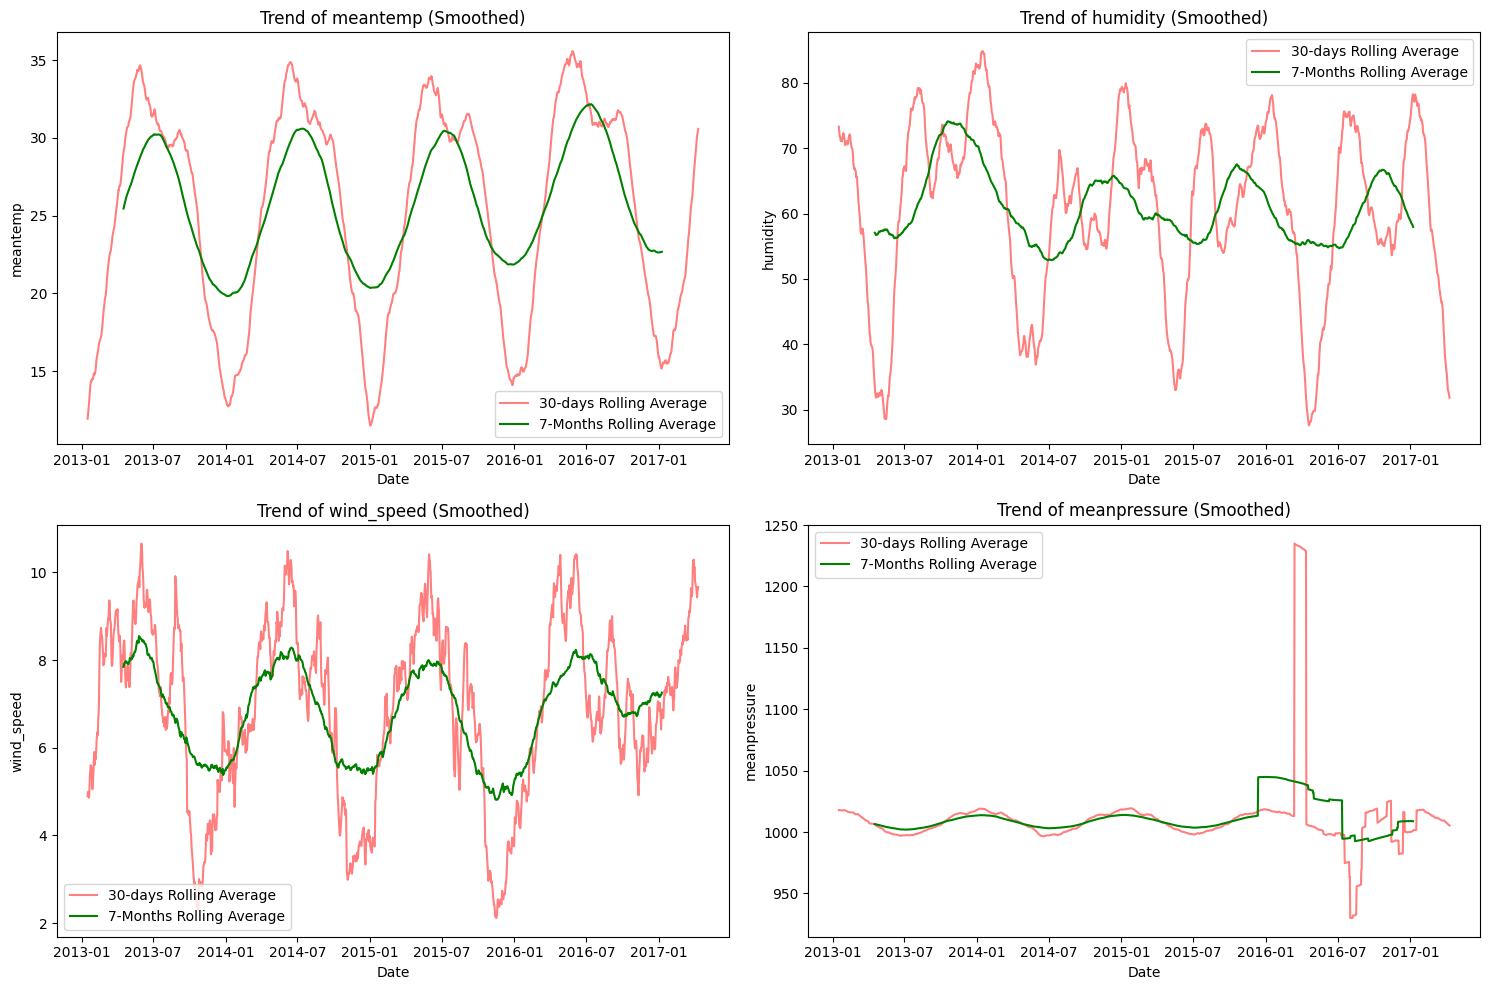

In [33]:
# Perform Rolling Average for Trend Smoothing
# Apply a rolling average to smooth short-term fluctuations
window_size = 30  # 30 days rolling window for monthly trends
window_size_month = 213  # 7 months rolling window for monthly trends

rolling_data = data[features].rolling(window=window_size, center=True).mean()
rolling_data_month = data[features].rolling(window=window_size_month, center=True).mean()


# Plot rolling averages
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    # plt.plot(data[feature], label="Usual days",alpha=0.5, color="blue")
    plt.plot(rolling_data[feature], label="30-days Rolling Average",alpha=0.5, color="red")
    plt.plot(rolling_data_month[feature], label="7-Months Rolling Average", color="green")
    plt.title(f"Trend of {feature} (Smoothed)")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()

**Key Obseravtion:** 
+ Meantemp: The smoothed lines confirm a seasonal cycle over years, with the 7-month rolling average showing a longer-term trend.
+ Humidity: Similar seasonality as temperature but with higher variability. The 7-month average captures gradual changes.
+ Wind Speed: Clear periodicity in the 30-day average; the 7-month rolling average smooths out spikes.
+ Mean Pressure: Overall consistent trend, with some deviations in the shorter-term (possibly data outliers).

## 4.3 Seasonal Decomposition
+ Further analysis to break each series into trend, seasonal, and residual components.

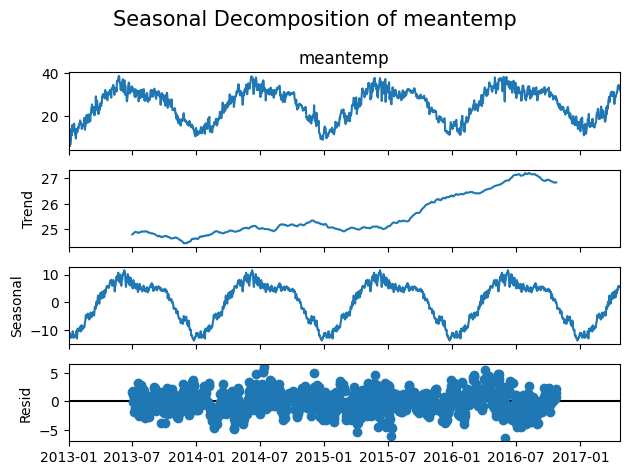

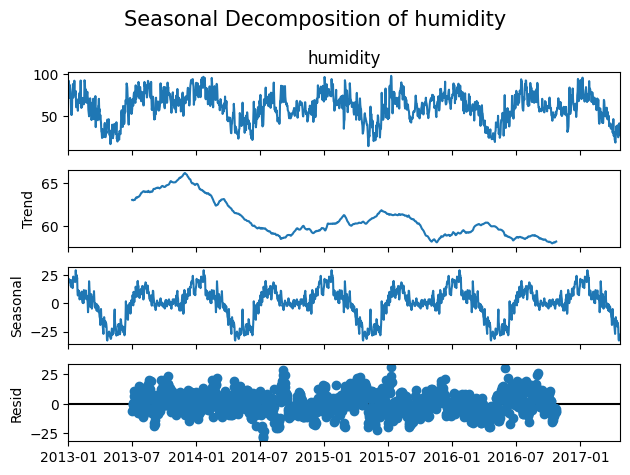

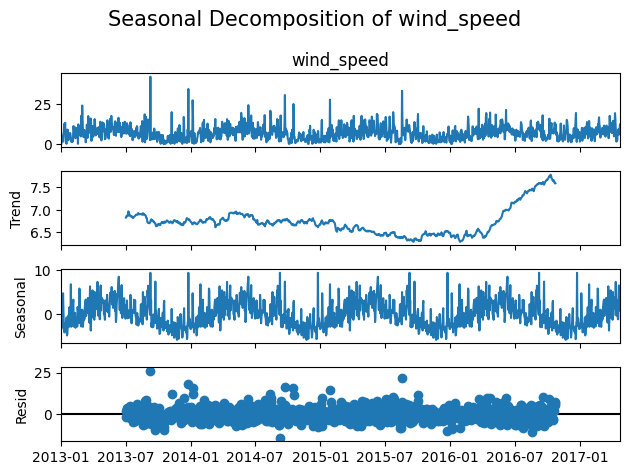

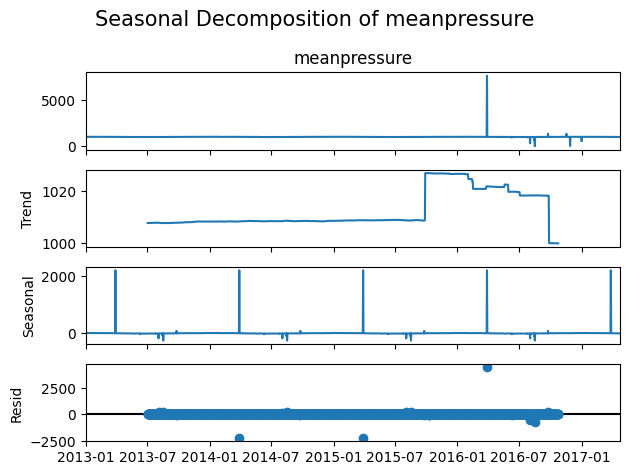

In [34]:
# Seasonal Decomposition
# Decompose each feature into Trend, Seasonal, and Residual components
for feature in features:
    decomposition = seasonal_decompose(data[feature], model="additive", period=365)  # Checking yearly seasonality since we have daily data
    decomposition.plot()
    plt.suptitle(f"Seasonal Decomposition of {feature}", fontsize=15)
    plt.tight_layout()
    plt.show()

## 4.4 Long-Term trend analysis
+ Seasonal cycle is seen over years, showing a longer-term trend.

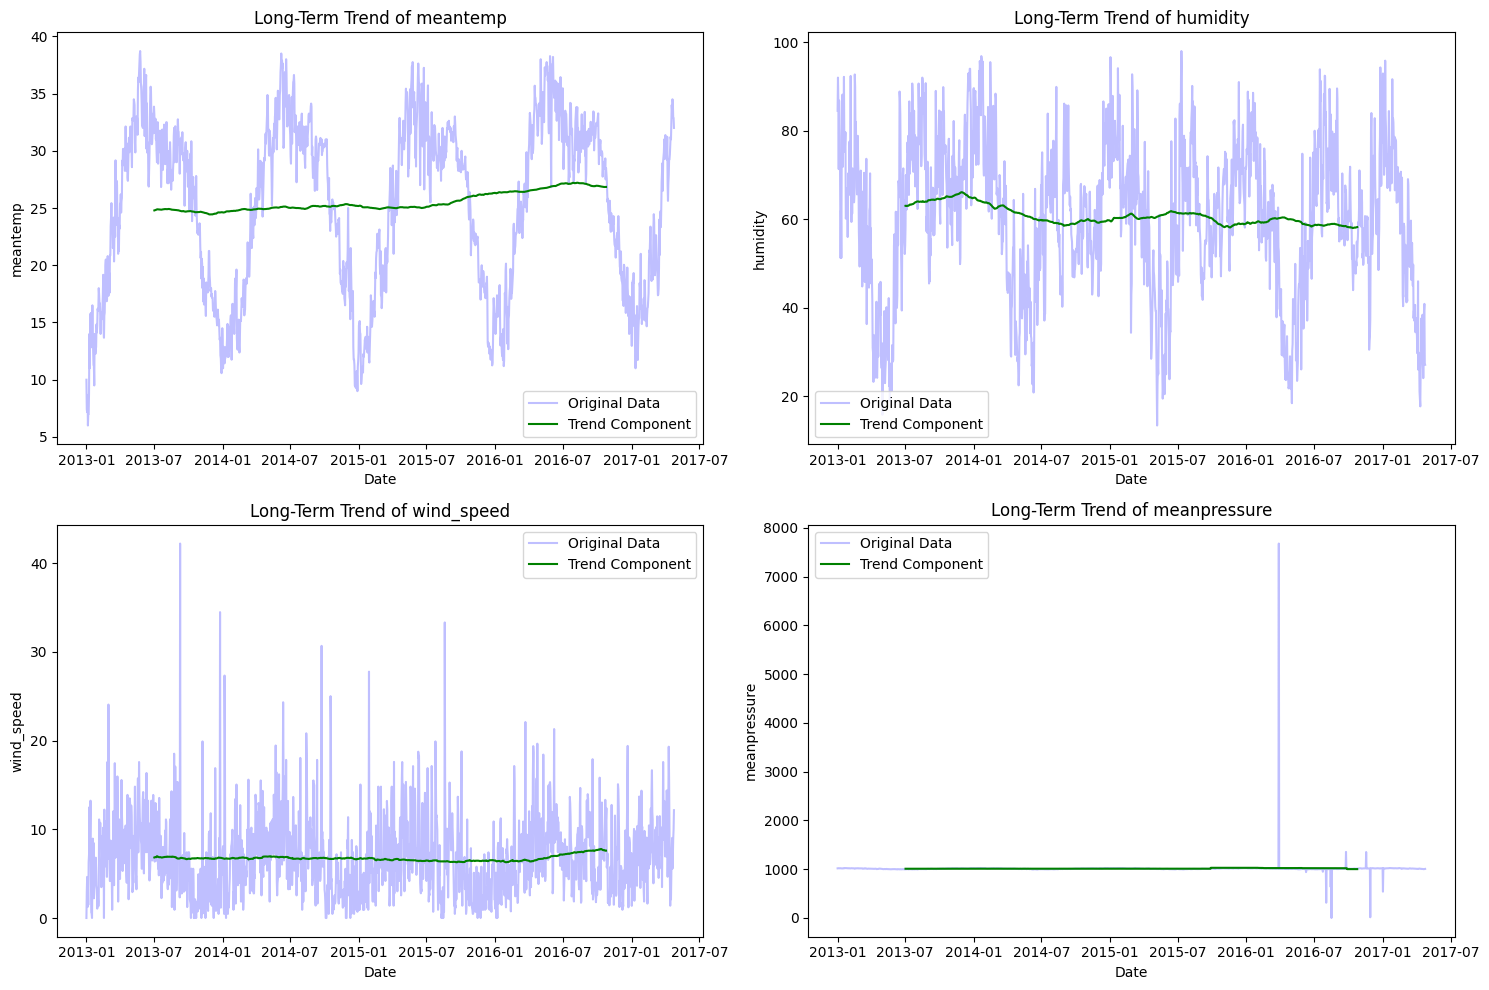

In [35]:
# Analyze Long-Term Trends
# Extract and plot just the trend component from decomposition
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    decomposition = seasonal_decompose(data[feature], model="additive", period=365)
    trend = decomposition.trend

    plt.subplot(2, 2, i)
    plt.plot(data[feature], label="Original Data", alpha=0.25, color="blue")
    plt.plot(trend, label="Trend Component", color="green")
    plt.title(f"Long-Term Trend of {feature}")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()

# 5. Correlation Between Variables

In [36]:
# Calculate correlation matrix
correlation_matrix = data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
              meantemp  humidity  wind_speed  meanpressure
meantemp      1.000000 -0.573904    0.287070     -0.036443
humidity     -0.573904  1.000000   -0.372625      0.000168
wind_speed    0.287070 -0.372625    1.000000     -0.018134
meanpressure -0.036443  0.000168   -0.018134      1.000000


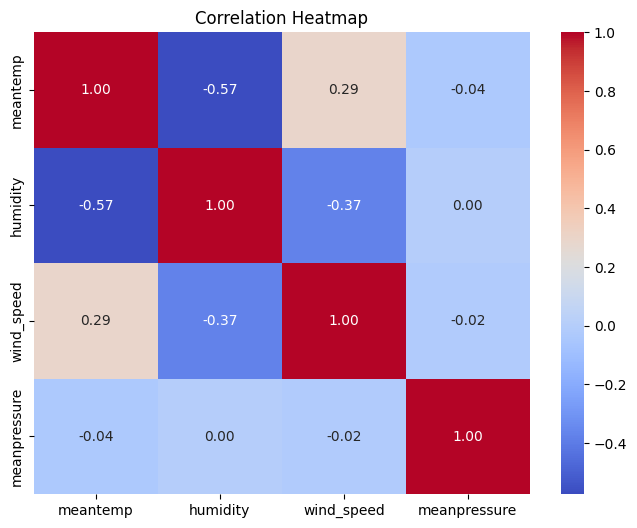

In [37]:
# Plot heatmap of correlations
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

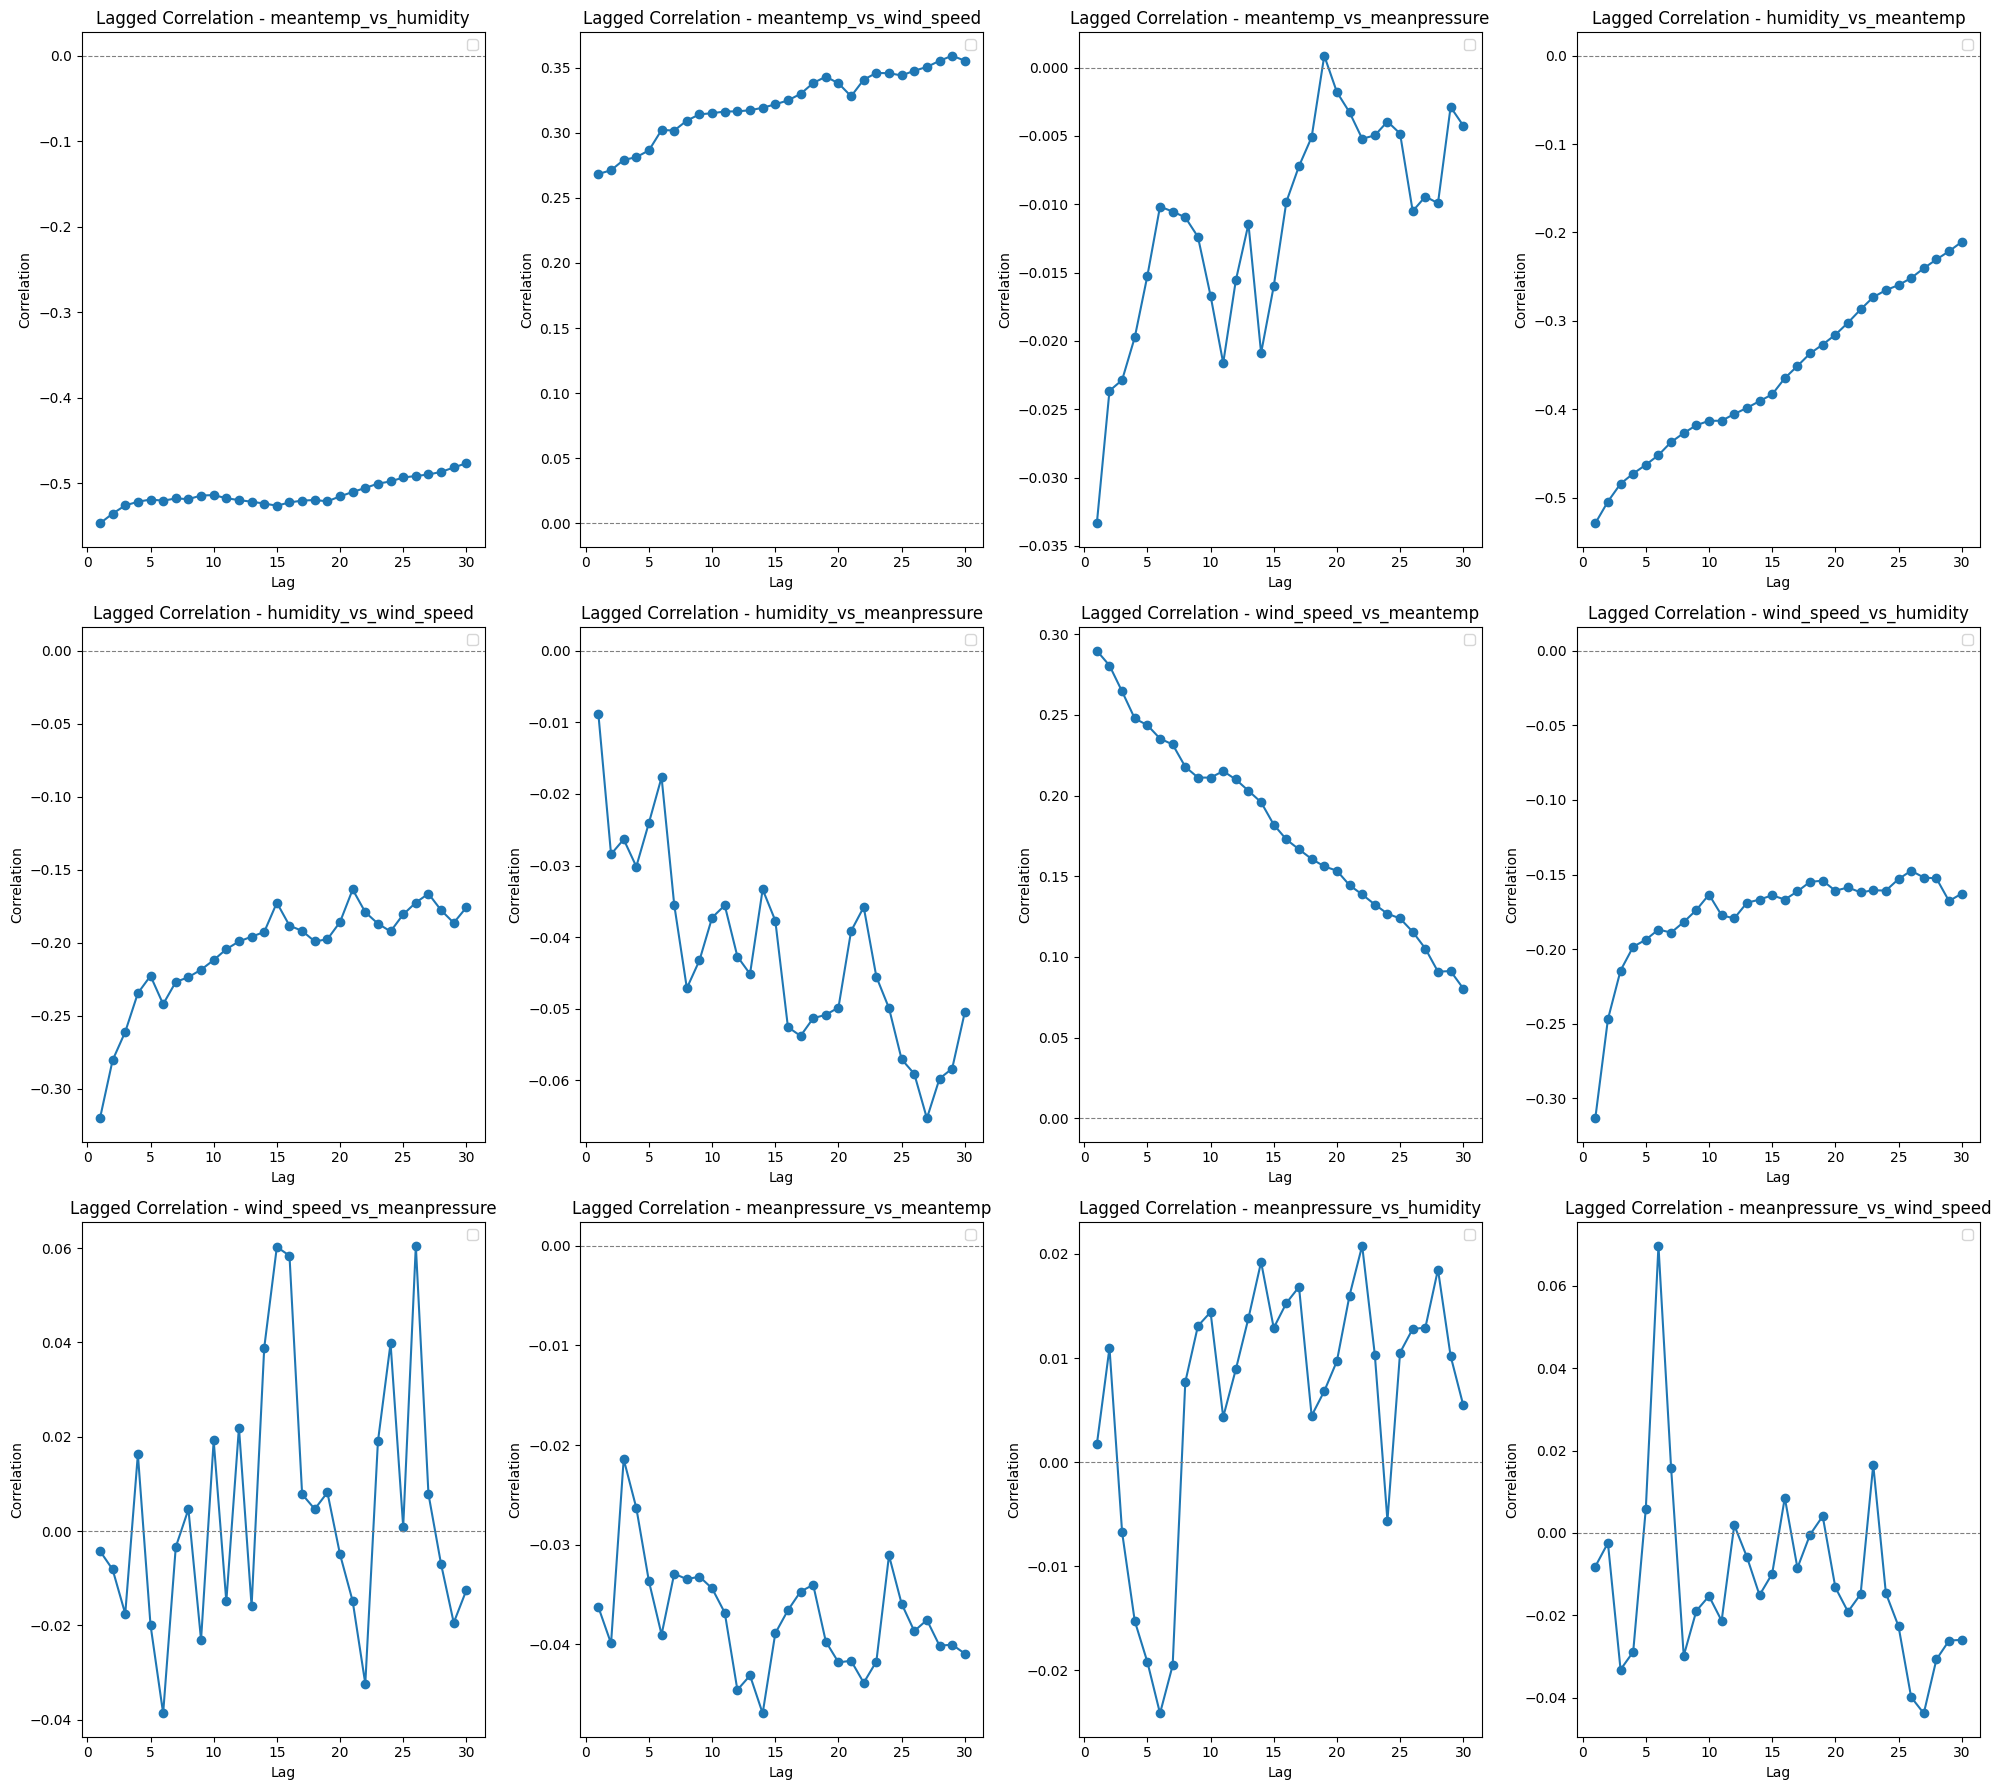

In [38]:
# Define the maximum number of lags and create the subplots
max_lag = 30
lags = range(1, max_lag + 1)
lagged_correlations = {}

for col1 in ['meantemp', 'humidity', 'wind_speed', 'meanpressure']:
    for col2 in ['meantemp', 'humidity', 'wind_speed', 'meanpressure']:
        if col1 != col2:
            lagged_correlations[f"{col1}_vs_{col2}"] = []
            for lag in lags:
                lagged_col = data[col2].shift(lag)
                correlation = data[col1].corr(lagged_col)
                lagged_correlations[f"{col1}_vs_{col2}"].append(correlation)


# Determine the number of rows and columns (at least 3 rows)
n_rows = 3
n_cols = int(np.ceil(len(lagged_correlations) / n_rows))

# Create a figure with the subplots (fixed 3 rows, dynamic columns)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))

# Flatten axes array to make indexing easier
axes = axes.flatten()

# Loop through lagged correlations and plot each on a separate subplot
for i, (key, values) in enumerate(lagged_correlations.items()):
    ax = axes[i]
    ax.plot(lags, values, marker='o')
    ax.set_title(f"Lagged Correlation - {key}")
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.legend()

# Turn off empty subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# 6. Anomaly Detection

In [39]:
# Function to detect anomalies using Z-Score
def detect_anomalies_zscore(df, column, threshold=3):
    # Calculate Z-scores for the column
    z_scores = zscore(df[column])
    # Identify anomalies where the absolute value of Z-score is greater than the threshold
    anomalies = np.abs(z_scores) > threshold
    return anomalies

# Function to detect anomalies using Rolling Window (Moving Average)
def detect_anomalies_rolling(df, column, window=5, threshold=2):
    # Calculate the rolling mean and rolling standard deviation
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    
    # Identify anomalies when the value deviates from the rolling mean by more than a threshold
    anomalies = np.abs(df[column] - rolling_mean) > (threshold * rolling_std)
    return anomalies

# Apply anomaly detection methods
columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
anomalies_zscore = {col: detect_anomalies_zscore(data, col) for col in columns}
anomalies_rolling = {col: detect_anomalies_rolling(data, col) for col in columns}


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


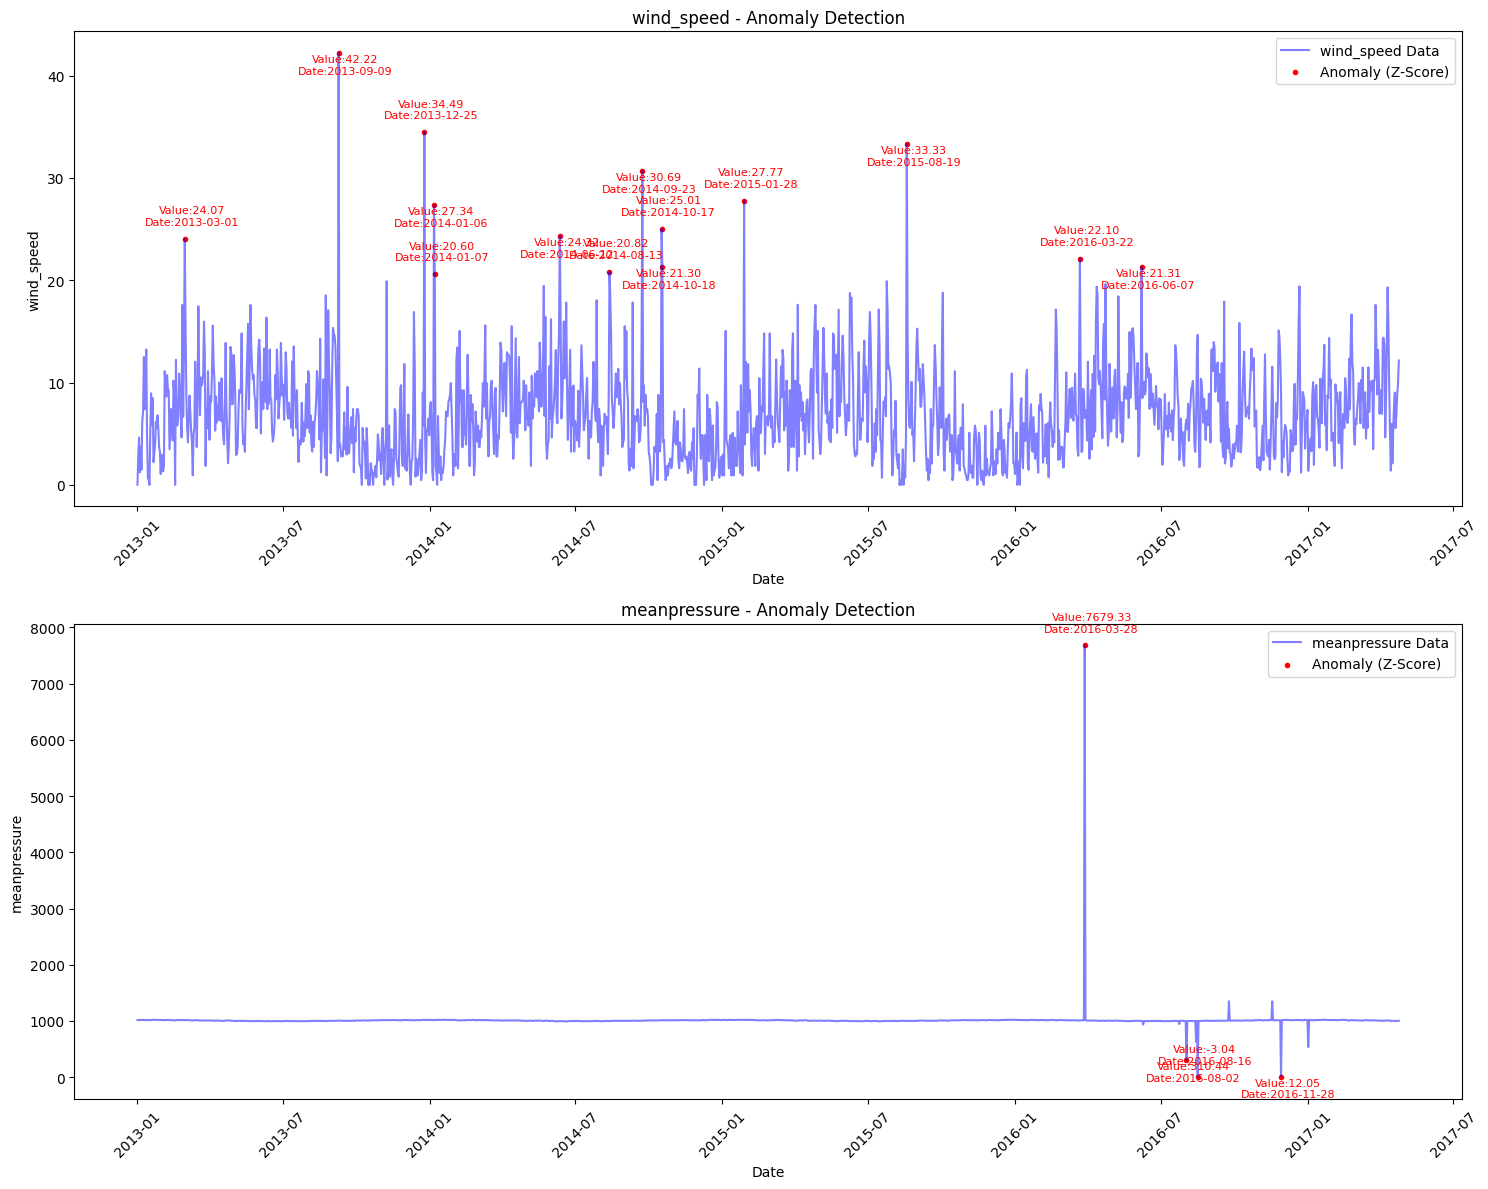

In [40]:
columns = ['wind_speed', 'meanpressure']

# Visualize anomalies
fig, axes = plt.subplots(len(columns), 1, figsize=(15, 6 * len(columns)))

if len(columns) == 1:
    axes = [axes]

for i, col in enumerate(columns):
    ax = axes[i]
    
    # Plot original data
    ax.plot(data['date_index'], data[col], label=f'{col} Data', color='blue', alpha=0.5)
    
    # Highlight anomalies (Z-Score)
    z_anomalies = data.loc[anomalies_zscore[col], ['date_index', col]]
    ax.scatter(z_anomalies['date_index'], z_anomalies[col], color='red', label='Anomaly (Z-Score)', marker='.')
    
    # Annotate Z-Score anomalies with staggered text positions
    for j, row in enumerate(z_anomalies.itertuples()):
        y_offset = 10 if j % 2 == 0 else -15  # Alternating offsets
        ax.annotate(f"Value:{row[2]:.2f}\nDate:{row.date_index.strftime('%Y-%m-%d')}", 
                    (row.date_index, row[2]), 
                    textcoords="offset points", xytext=(5, y_offset), 
                    ha='center', fontsize=8, color='red')

    ax.set_title(f'{col} - Anomaly Detection')
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

# 7. TSA Forecasting

## 7.1 Data Preparation

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1575 entries, 2013-01-01 to 2017-04-24
Freq: D
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   meantemp      1575 non-null   float64       
 1   humidity      1575 non-null   float64       
 2   wind_speed    1575 non-null   float64       
 3   meanpressure  1575 non-null   float64       
 4   date_index    1575 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 106.1 KB


In [42]:
data = data.drop(['date_index'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1575 entries, 2013-01-01 to 2017-04-24
Freq: D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1575 non-null   float64
 1   humidity      1575 non-null   float64
 2   wind_speed    1575 non-null   float64
 3   meanpressure  1575 non-null   float64
dtypes: float64(4)
memory usage: 93.8 KB


In [43]:
# Round the floating point columns to 3 decimal places
data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].round(3)

data.head(5)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000,84.500,0.000,1015.667
2013-01-02,7.400,92.000,2.980,1017.800
2013-01-03,7.167,87.000,4.633,1018.667
2013-01-04,8.667,71.333,1.233,1017.167
2013-01-05,6.000,86.833,3.700,1016.500


## 7.2 ADF Test for stationarity

In [44]:
# ADF Test for stationarity
def adf_test(series):
    result = adfuller(series.dropna())  
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

# Check stationarity for meantemp
print("ADF Test for stationarity - Meantemp:")
adf_test(data['meantemp'])
print("\nADF Test for stationarity - Humidity:")
adf_test(data['humidity'])
print("\nADF Test for stationarity - Wind_speed:")
adf_test(data['wind_speed'])
print("\nADF Test for stationarity - Meanpressure:")
adf_test(data['meanpressure'])


ADF Test for stationarity - Meantemp:
ADF Statistic: -2.375792352009258
p-value: 0.14868571810583714
Data is NOT stationary

ADF Test for stationarity - Humidity:
ADF Statistic: -3.6366485787708482
p-value: 0.005097823978890665
Data is stationary

ADF Test for stationarity - Wind_speed:
ADF Statistic: -4.005865698502911
p-value: 0.001380106268152165
Data is stationary

ADF Test for stationarity - Meanpressure:
ADF Statistic: -39.52816302979258
p-value: 0.0
Data is stationary


## -------------------------------------------------InProgress-------------------------------------------